In [109]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [121]:
%matplotlib inline
import re
import torch
import collections
import random
import math
import time
from torch import nn
import matplotlib.pyplot as plt
# import numpy as np
# from torch.utils.data.dataloader import DataLoader
# import torch.utils.data as data_utils
from tqdm.notebook import tqdm

from d2l import torch as d2l

from torch.nn import functional as F

seedy = 666
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### All of the code below is straight from the textbook and/or my brain. But mostly the textbook, like pure copypasta.

## 1) Download and tokenize the Shakespeare dataset at a chracter level. 

In [111]:
f_name = "shakespeare.txt"

def read_it():  #@save
    with open(f_name, 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='char'):  #@save
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

## WE HAVE TOKENIZED !!!
content = read_it()
tokens = tokenize(content)
print("Example tokens:",tokens[0])

Example tokens: ['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'c', 'o', 'm', 'p', 'l', 'e', 't', 'e', ' ', 'w', 'o', 'r', 'k', 's', ' ', 'o', 'f', ' ', 'w', 'i', 'l', 'l', 'i', 'a', 'm', ' ', 's', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e', ' ', 'b', 'y', ' ', 'w', 'i', 'l', 'l', 'i', 'a', 'm', ' ', 's', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']


## 2) Train a "vanilla" RNN (as described in chapter 8 of the textbook on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.


### <font color=blue> Here is code from the textbook that deals with the corpus and its associated vocab.

In [112]:
class Vocab:  
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)
        
        self.unk = 0
        uniq_tokens = ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def load_corpus(max_tokens=-1):
    lines = read_it()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [122]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [123]:
class SeqDataLoader:  
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [124]:
def load_data(batch_size, num_steps, use_random_iter=False, max_tokens=8000000):
    """Return the iterator and the vocabulary of thedataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [125]:
def predict(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [126]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [127]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
#     return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
    return l ## We want to return loss !!!

In [128]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
#     animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
#                             legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict_it = lambda prefix: predict(prefix, 50, net, vocab, device)
    
    # Train and predict
    losses = []
    for epoch in tqdm(range(num_epochs), total=num_epochs):
#         ppl, speed = train_epoch_ch8(
#             net, train_iter, loss, updater, device, use_random_iter)
        this_loss = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
    
        if (epoch + 1) % 10 == 0:
            print(predict_it('my love'))
#             animator.add(epoch + 1, [ppl])
        losses.append(this_loss)

#     print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(f'loss {this_loss:5.3f}')

    print(predict_it('my love'))
    print(predict_it('where art thou'))
    
    return losses

In [129]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [130]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs = 80
lr = 1

In [131]:
s = time.time()
losses = train_ch8(net, train_iter, vocab, lr, num_epochs, device)
e = time.time()
print("%5.3f mins" % ((e-s)/60))

my love to the palaceenter the land the land the land the
my love the states the fair discorn d the faith i see the
my love to make a company our life and the fair discordin
my love to make a states the search your company which wi
my love to make the part of the part of the part of the p
my love to make the pardon the stay my lord the stay my l
my love to the prove to the prove to the prove to the pro
my love s sight s sight s sight s sight s sight s sight s

loss 1.693
my love s sight s sight s sight s sight s sight s sight s
where art thou did come to make the pardon the pardon the pardon
24.973 mins


In [132]:
run = "2"

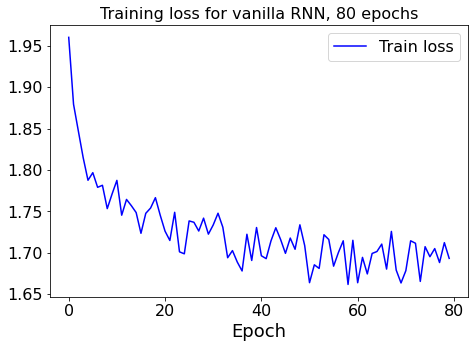

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline   

plt.rc('font', size=16) 
plt.figure(figsize=(7.5,5))

plt.plot(losses,label='Train loss',c='blue')

plt.xlabel("Epoch")
plt.title("Training loss for vanilla RNN, 80 epochs")
plt.legend(loc='upper right')
plt.savefig("hw6_losses_rnn_%s" % run)
plt.show()

### <font color=blue> Here are some predictions.

In [134]:
tests = ["hello ",
         "my name is ",
         "i love cheese ",
         "i cannot believe it is not butter ",
         "a cat will ",
         "forks",
         "anger"]

for i,test in enumerate(tests):
    prediction = predict(test, 70, net, vocab, device)[len(test):]
    print("%d) %s ... %s" % (i+1,test,prediction))

1) hello  ... see the pardon the pardon the pardon the pardon the pardon the pardon 
2) my name is  ... the pardon the pardon the pardon the pardon the pardon the pardon the 
3) i love cheese  ... of the pardon the pardon the pardon the pardon the pardon the pardon t
4) i cannot believe it is not butter  ... the pardon the pardon the pardon the pardon the pardon the pardon the 
5) a cat will  ... not so shall be so sir i shall be so sir i shall be so sir i shall be 
6) forks ...  and the pardon the pardon the pardon the pardon the pardon the pardon
7) anger ...  than the pardon the pardon the pardon the pardon the pardon the pardo


In [66]:
# with open('losses_rnn.txt', 'w') as the_file:
#     for line in losses:
#         the_file.write(str(line.item()))



## 3) Train a GRU RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?


In [137]:
num_hiddens = 256
num_steps = 35
train_iter, vocab = load_data(batch_size, num_steps)

batch_size = 32
num_epochs = 80
lr = 1

gru_layer = nn.GRU(len(vocab), num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
losses = train_ch8(model, train_iter, vocab, lr, num_epochs, device)

my love to the particular and the project gutenberg tm el
my love to me to the particular to the particular to the 
my love to hear the court and there is no more to the par
my love s sons to me to the court of the shape of the sta
my love to him that i have seen thee to the court shall b
my love to the court and there is no more to the court an
my love to her to the state of the state of the state of 
my love to the gods to the gods to the gods to the gods t

loss 1.406
my love to the gods to the gods to the gods to the gods t
where art thou to the greeks and the good man s tongueto be the 


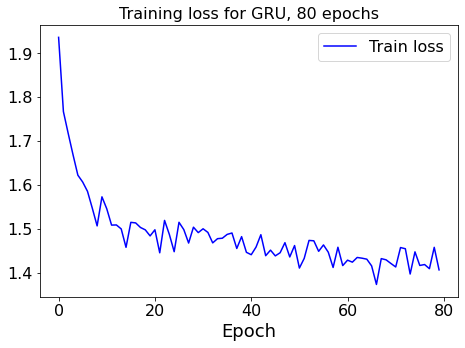

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline   

plt.rc('font', size=16) 
plt.figure(figsize=(7.5,5))

plt.plot(losses,label='Train loss',c='blue')

plt.xlabel("Epoch")
plt.title("Training loss for GRU, 80 epochs")
plt.legend(loc='upper right')
plt.savefig("hw6_losses_gru_%s" % run)
plt.show()

In [139]:
tests = ["hello ",
         "my name is ",
         "i love cheese ",
         "i cannot believe it is not butter ",
         "a cat will ",
         "forks",
         "anger"]

for i,test in enumerate(tests):
    prediction = predict(test, 70, model, vocab, device)[len(test):]
    print("%d) %s ... %s" % (i+1,test,prediction))

1) hello  ... sir to make the court of the state of the state of the state of the st
2) my name is  ... the man s tongue to the gods to the gods to the gods to the gods to th
3) i love cheese  ... to the gods to the gods to the gods to the gods to the gods to the god
4) i cannot believe it is not butter  ... the good man s tongueto be the prince and the good man s tongue to the
5) a cat will  ... not be so good my lord the state of the state of the state of the stat
6) forks ...  and the gods to the gods to the gods to the gods to the gods to the g
7) anger ... s to the gods to the gods to the gods to the gods to the gods to the g


In [140]:
losses[-1]

tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)

## 4) Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?
